# PROGETTO MOBD
    Authors: Giacomo Solfizi, Edoardo Rossi
    Project: MOBD
    Description: Script che genera e salva il migliore classificatore.

## Import Packege

In [1]:
# Packege principali
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Rimpiazzo NaN
from sklearn.impute import KNNImputer

# ELimino Outliers Multivariati
from collections import Counter
from sklearn.cluster import DBSCAN
from imblearn.over_sampling import SMOTE

# Spit Dati
import sklearn.model_selection as model_select
import sklearn.metrics as metrics

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Salvataggio Classificatore
import pickle
# Variabili Globali.
target = 'CLASS'
pipeline_path = 'best_classificatore.sav'

### Importo il DataSet

In [2]:
#Importo dati
dataset = pd.read_csv('training_set.csv')

In [3]:
# Separiamo i valori dalle features dalle classi
target = 'Label'
x = dataset.drop(target, axis=1)
# --> print('Variabili Indipendenti X:\n', x)
# Separiamo i valori delle Classi dalle features
y = dataset[[target]]
# --> print('\nVariabili Dipendenti Y:\n', y)
# Lista delle features
features_list = x.columns.values.tolist()
# --> print('Lista Features:\n', features_list)

### Rimpiazzo subito i NaN

In [4]:
imputer = KNNImputer(n_neighbors=2)
imputer.fit(x)
file_imputer = open('imputer.sav','wb')
pickle.dump(imputer,file_imputer)
file_imputer.close()
dati_imputati = imputer.fit(x).transform(x)
# Dataset senza NaN in forma di DataFrate
X_imputer = pd.DataFrame(dati_imputati)

In [5]:
#PICKLE

In [ ]:
### Dataset senza NaN --> Ora eliminare Outliers Multivariati

In [6]:
Scanner_pre = DBSCAN(eps=6.6, min_samples=10,n_jobs = -1)
file_dbscan = open('cluster.sav','wb')
pickle.dump(Scanner_pre,file_dbscan)
file_dbscan.close()
Scanner = Scanner_pre.fit(X_imputer)
# --> print('Nei_cluster, Fuori_Cluster -->',Counter(Scanner.labels_))
# --> print('Numero di outliersMultivariti trovati -->', Scanner.labels_[Scanner.labels_ == -1] .size)
Outliers = X_imputer[Scanner.labels_==-1].index.values
# --> print('Indici degli Outliers:\n', Outliers)
x_final = pd.DataFrame(X_imputer).drop(index = Outliers)
y_final = y.drop(index = Outliers)

In [7]:
#PICKLE

### Ora Possiamo effettuare Split in Training set e Test Set

In [8]:
oversample = SMOTE()
file_smote = open('smote.sav','wb')
pickle.dump(oversample,file_smote)
file_smote.close()
x_final, y_final = oversample.fit_resample(x_final, y_final)
# --> print(x_final.size)
# --> print(y_final.size)

In [9]:
#PICKLE

In [10]:
# Split in training-set e test-set.
train_x, test_x, train_y, test_y = \
        model_select.train_test_split(x_final, y_final,
                                      test_size=0.2,
                                      random_state=42,
                                      stratify=y_final)
# --> print('\nTraining set shape:', train_x.shape, train_y.shape)
# --> print('Test set shape:', test_x.shape, test_y.shape)

### Classi e funzioni

In [11]:
# Creiamo la classe che rimpiazza gli outliers che ci servira per pipeline e perchè KNN non rimpiazza direttamente gli outliers
# ma i nan quindi bisogna anche ricreare il metodo fit e il trasform

class KNNReplacerIQR(KNNImputer):
    """Pipeline-compliant KNNReplacer, based on IQR."""

    def __init__(self, n_neighbors=2):
        super().__init__(n_neighbors=n_neighbors)
        self.lower_bound = None
        self.upper_bound = None
        self.imputer = KNNImputer(n_neighbors=n_neighbors)

    def fit(self, x, y=None):
        """Computes IQR bound and fits the imputer on the data."""
        x = pd.DataFrame(x)
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound = q1 - (1.5* iqr)
        self.upper_bound = q3 + (1.5* iqr)
        self.imputer.fit(
            x.where(~((x < self.lower_bound) | (x > self.upper_bound)), np.nan)
        )
        return self

    def transform(self, x, y=None):
        """Detects outliers and replaces them with the imputer."""
        x = pd.DataFrame(x)
        x.where(~((x < self.lower_bound) | (x > self.upper_bound)),
                np.nan,
                inplace=True)
        return self.imputer.transform(x)

In [12]:
def show_confusion_matrix(cm, f1_score, title):
    """Displays confusion matrix with annotations."""
    # Crea 'assi'.
    group_counts = ["{0:0.0f}\n".format(value) for value in cm.flatten()]
    group_percentages =\
        ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    box_labels =\
        [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0], cm.shape[1])
    # Mostra la confusion matrix.
    sns.heatmap(cm,
                annot=box_labels,
                fmt="",
                cmap="YlGnBu",
                cbar=False,
                linewidths=1.0)\
        .set(title=title,
             xlabel='Predicted class\n\nF1 macro: %0.4f' % f1_score,
             ylabel='Actual class')
    plt.show()

### Pipeline

In [13]:
# Pipeline Principale
Pipe_Knn_Bagging = Pipeline([   ('replacer', KNNReplacerIQR()),
                                ('pre-process-QDA',PolynomialFeatures(degree=3)),
                                ('scaler',StandardScaler()),
                                ('decomposition',PCA(random_state = 42)),
                                ('feature_selection', SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False))),
                                ('classifier',BaggingClassifier(
                                                 base_estimator=QDA(reg_param = 0.001,store_covariance =True,tol = 0.001),
                                                 n_jobs = -1,
                                                 random_state = 42))
                            ])

In [14]:
grid_Pipe_Knn_Bagging = {'replacer__n_eighbors': [2]}

In [15]:
gs_Bagging_knn = model_select.GridSearchCV( Pipe_Knn_Bagging ,
                                               param_grid =  grid_Pipe_Knn_Bagging,
                                               scoring='f1_macro',
                                               cv=5,
                                               refit=True,
                                               n_jobs=-1)

In [16]:
# Lista pipeline
grids = [gs_Bagging_knn]
#Dizionario delle pipeline
grid_dict_pipe = {0:'Best_Pipe_Score'}

### Test Pipeline

In [17]:
# Fit the grid search objects and look for the best model.
print("\nMODEL OPTIMIZATIONS STARTED")
best_f1 = 0.0
best_idx = 0
best_pipe = None
for idx, pipe_gs in enumerate(grids):
    print('Currently trying model: %s' % grid_dict_pipe[idx])
    print(pipe_gs)

    # Perform grid search.
    pipe_gs.fit(train_x, train_y[target])

    # Dump detailed scores on a file.
    results_file = open(grid_dict_pipe[idx] + '_results.txt', 'w')

    # Print scores and update bests.
    print("\nGrid scores:")
    means = pipe_gs.cv_results_['mean_test_score']
    stds = pipe_gs.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds,
                                 pipe_gs.cv_results_['params']):
        print("%0.4f (+/-%0.03f) for %r" % (mean, std * 2, params))
        results_file.write("%0.4f (+/-%0.03f) for %r\n"
                           % (mean, std * 2, params))
    print("\nBest parameters:")
    print(pipe_gs.best_params_)
    print("\nBest score: %0.4f" % pipe_gs.best_score_)
    if pipe_gs.best_score_ > best_f1:
        best_f1 = pipe_gs.best_score_
        best_idx = idx
        best_pipe = pipe_gs.best_estimator_
    results_file.write("\nBest parameters:\n%r\n" % pipe_gs.best_params_)
    results_file.write("\nBest score: %0.4f\n" % pipe_gs.best_score_)

    results_file.close()


MODEL OPTIMIZATIONS STARTED
Currently trying model: Best_Pipe_Score
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('replacer', KNNReplacerIQR()),
                                       ('pre-process-QDA',
                                        PolynomialFeatures(degree=3)),
                                       ('scaler', StandardScaler()),
                                       ('decomposition', PCA(random_state=42)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LinearSVC(C=0.01,
                                                                            dual=False,
                                                                            penalty='l1'))),
                                       ('classifier',
                                        BaggingClassifier(base_estimator=QuadraticDiscriminantAnalysis(reg_param=0.001,
                                                              

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


### Salvataggio e Test dei dati

In [18]:
def evaluate_classifier(classifier, data_x, data_y, matrix_title='', show=True):
    pred_y = classifier.predict(data_x)
    confusion_matrix = metrics.confusion_matrix(data_y, pred_y)
    f1_score = metrics.f1_score(data_y, pred_y, average='macro')
    if show:
        show_confusion_matrix(confusion_matrix, f1_score, matrix_title)
    return f1_score

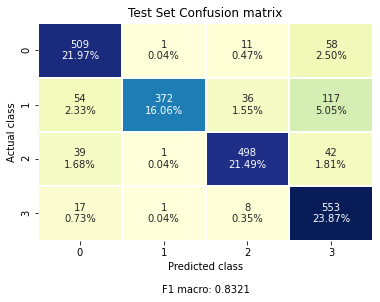


Test set F1 macro: 0.8321


In [19]:
# Valuta la pipeline sul test set
print('\nTest set F1 macro: %0.4f'
          % evaluate_classifier(best_pipe,
                                test_x,
                                test_y[target],
                                'Test Set Confusion matrix'))


RE-FITTING BEST PIPELINE ON WHOLE DATASET


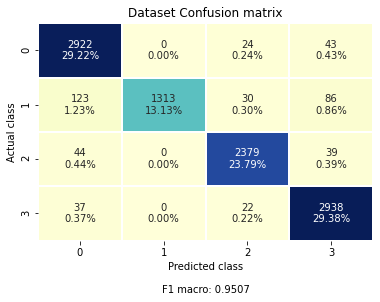


(Pre-save) Dataset F1 macro: 0.9507


In [20]:
# Refitta tutta la pipeline sull'intero dataset
print("\nRE-FITTING BEST PIPELINE ON WHOLE DATASET")
best_pipe = best_pipe.fit(x, y[target])
print('\n(Pre-save) Dataset F1 macro: %0.4f'
          % evaluate_classifier(best_pipe,
                                x,
                                y[target],
                                'Dataset Confusion matrix'))

In [21]:
# Salva il modello migliore trovato
with open(pipeline_path, 'wb') as model_file:
        pickle.dump(best_pipe, model_file)

In [22]:
# Controlla se hai salvato bene il classificatore.
with open(pipeline_path, 'rb') as model_file:
        model = pickle.load(model_file)
print('\n(Post-save) Dataset F1 macro: %0.4f'
          % evaluate_classifier(model,
                                x,
                                y[target],
                                show=False))


(Post-save) Dataset F1 macro: 0.9507
